In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow.keras as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import glob
import seaborn as sns
import json

In [2]:
# Set image size
s = 150
dataset = []
label = []

# Define directory paths
Balaat = 'Balaat'
Fool_disease = 'Fool disease'
Inflorescence_rot = 'Inflorescence rot'
Rhynchophorus_ferrugineus_insect = 'Rhynchophorus ferrugineus insect' 

# Function to decode and append images
def decode_and_append_images(directory, class_label):
    images = glob.glob(os.path.join(directory, '*'))
    for image in images:
        img = cv2.imread(image)
        if img is not None:  # Ensure image was successfully read
            img = cv2.resize(img, (s, s))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # Normalize to [0, 1]
            img = img.astype(np.float32)  # Cast to float32
            dataset.append(img)
            label.append(class_label)

# Decode images for DFU and Wound
decode_and_append_images(Balaat, 0)
decode_and_append_images(Fool_disease, 1)
decode_and_append_images(Inflorescence_rot, 2)
decode_and_append_images(Rhynchophorus_ferrugineus_insect, 3)

In [3]:
# Convert to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Display the shape of the dataset
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (389, 150, 150, 3)
Label shape: (389,)


In [4]:
# Shuffle the data
dataset, label = shuffle(dataset, label, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.25, stratify=label, random_state=43)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [5]:
# Build the model
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(s, s, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)      

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(X_train)

In [7]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop]
)

Epoch 1/30


10/10 [==============================] - 17s 871ms/step - loss: 1.4323 - accuracy: 0.8179 - val_loss: 1.1020 - val_accuracy: 0.9286
Epoch 2/30
10/10 [==============================] - 8s 715ms/step - loss: 0.5021 - accuracy: 0.9244 - val_loss: 0.4703 - val_accuracy: 0.9286
Epoch 3/30
10/10 [==============================] - 8s 763ms/step - loss: 0.3938 - accuracy: 0.9244 - val_loss: 0.3520 - val_accuracy: 0.9286
Epoch 4/30
10/10 [==============================] - 8s 767ms/step - loss: 0.3949 - accuracy: 0.9244 - val_loss: 0.4473 - val_accuracy: 0.9286
Epoch 5/30
10/10 [==============================] - 8s 739ms/step - loss: 0.3607 - accuracy: 0.9244 - val_loss: 0.3107 - val_accuracy: 0.9286
Epoch 6/30
10/10 [==============================] - 9s 874ms/step - loss: 0.3494 - accuracy: 0.9244 - val_loss: 0.3050 - val_accuracy: 0.9286
Epoch 7/30
10/10 [==============================] - 10s 1s/step - loss: 0.3069 - accuracy: 0.9244 - val_loss: 0.2544 - val_accuracy: 0.9286
Epoch

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Use the class labels for evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

4/4 [==============================] - 0s 74ms/step - loss: 0.1028 - accuracy: 0.9796
Loss: 0.10275699943304062, Accuracy: 0.9795918464660645
4/4 [==============================] - 1s 73ms/step
Accuracy: 0.9795918367346939
Precision: 0.9720496894409938
Recall: 0.9795918367346939
F1 Score: 0.9742261307333238


F:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


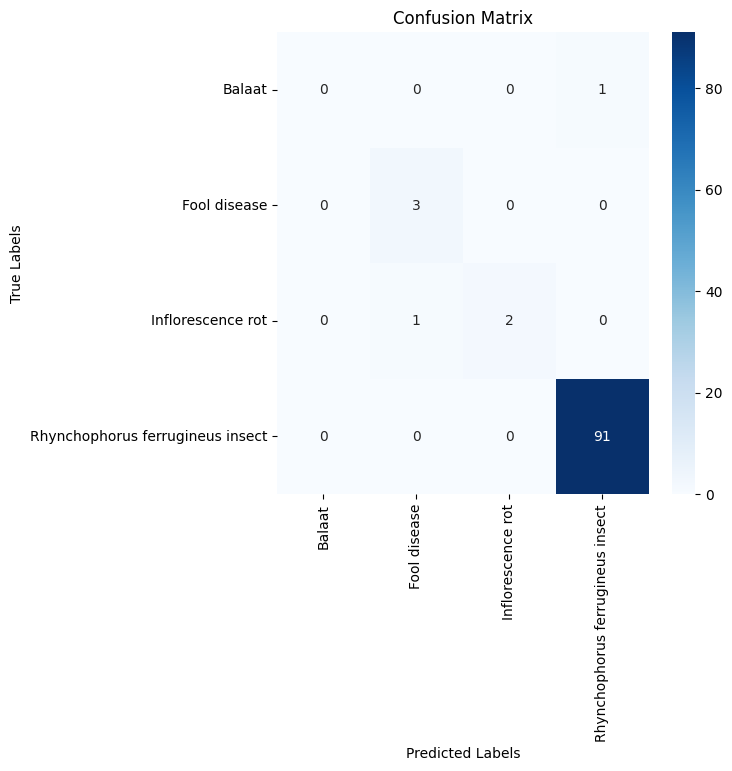

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Balaat', 'Fool disease','Inflorescence rot','Rhynchophorus ferrugineus insect' ], yticklabels=['Balaat', 'Fool disease','Inflorescence rot','Rhynchophorus ferrugineus insect' ])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

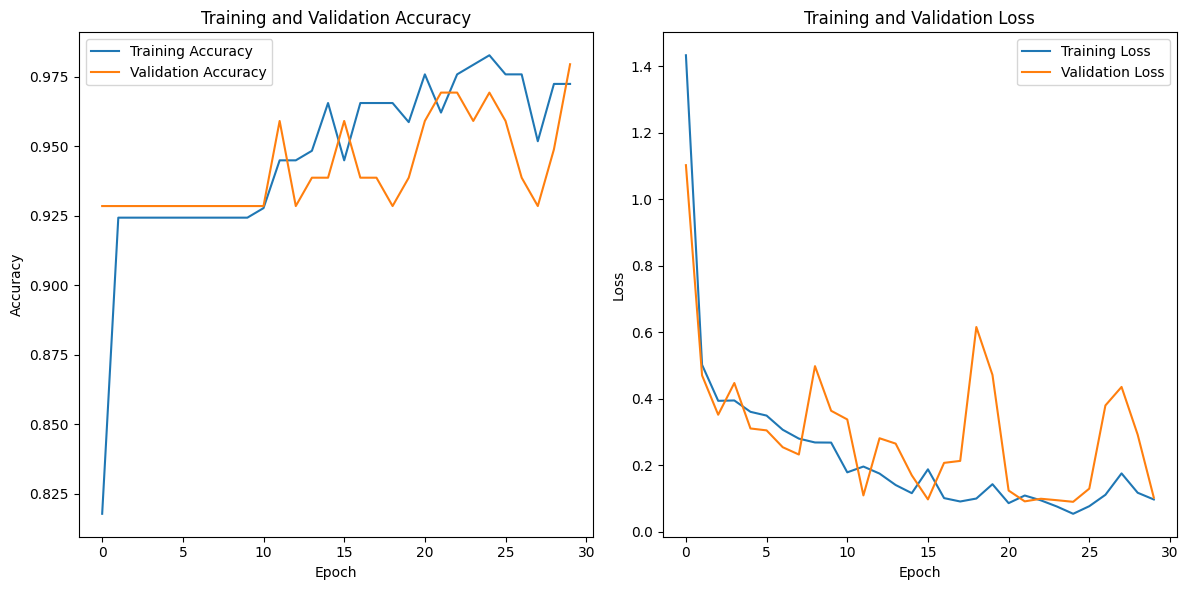

In [11]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model as .h5 file
model.save('Plant diseases.h5')
print("Model saved as 'Plant diseases.h5'")

# Save the model architecture as JSON
model_json = model.to_json()
with open("Plant diseases.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model architecture to 'Plant diseases.json'")
